1 train test split ( fonction sklearn)
2 séparation variable caté et continues -> standardscaler sur continues , target encoding sur les categ
3 scaler (standardscaler) -> .fit(X_train_continue) -> .transform(X_trai_continue)application de l'encoding pareil avec le target encoder
4 sur le X_test tu feras scaler.transform(X_test_continue)
5 une fois le jeu de données standardisé faire linear reg
6 linearreg.fit(X_train_scale ( conding + standardisation), y_train)
7 linearreg.predict(X_test_scale (encoding + standardisation))
8 métriques pour mesurer l'efficacité du modèle (RMSE/MSE/MAE/Rsquare)
9 Tester deux regression avec deux y différents -> le y basique siteenergy use basique / site_energy_use passé au log -> np.log(site_energy_use)

10 une fois ca fait tester avec d'autres modèles 
- linear reg avec penalty -> lasso, ridge 
- Random Forest Regressor
- XGBoostRegressor
Pour optimiser les paramètres eg.(coefficient de lasso, ridge) _> utiliser une GridSearchCV ( combainaison de gridsearch + cross validation (skleanr))
Si trop long tester avec RandomizeSearchCV (sklearn)
pour évaluer les modèles récupérer les best_score (attribut de gridsearchCV ou de random...), les best_params


# IMPORTATION

In [1]:
import csv
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport #https://pandas-profiling.github.io/pandas-profiling/docs/master/index.html
#import qgrid

import pingouin as pg
import scipy
from pca import pca #pip install pca https://github.com/erdogant/pca

import ast #Tranfromer un dictioner

/home/chispitas/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost #pip install xgboost

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import joblib
from scipy.stats import randint
import shap #https://shap.readthedocs.io/en/latest/index.html

2021-12-03 11:56:33.049268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 11:56:33.049298: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
dirDATA = '/media/chispitas/DATOS/Documento/Estudios/DataScientist/Projecto/P4-Anticipez les besoins en consommation electrique de batiments/Code/'
direc0 = '/media/chispitas/DATOS/Documento/Estudios/DataScientist/Projecto/P4-Anticipez les besoins en consommation electrique de batiments/Code/Data/'

str_dfML = direc0 + 'dfML.csv'

In [6]:
#dfDATA_Original_15 = pd.read_csv(dir_15, encoding='utf-8', nrows = 10) #, delimiter='\t'
dfML = pd.read_csv(str_dfML, encoding='utf-8') #, delimiter='\t'
dfML = dfML.convert_dtypes()
dfML = dfML.set_index('OSEBuildingID')
dfML = dfML.sort_values(['SiteEnergyUse(kBtu)'], ascending = True)
dfML.dtypes

SiteEnergyUse(kBtu)             Float64
GHGEmissions(MetricTonsCO2e)    Float64
PropertyGFABuilding(s)            Int64
NumberofFloors                    Int64
PrimaryPropertyType              string
Neighborhood                     string
YearBuilt_10y                     Int64
ENERGYSTARScore                   Int64
dtype: object

In [7]:
dfDESCRIPTION = dfML.describe(include='all')
LEN = len(dfML)
dfTAUX = dfDESCRIPTION.T

dfTAUX['%full'] = (dfTAUX['count']/LEN)*100
dfTAUX['%unique'] = (1-dfTAUX['unique']/dfTAUX['count'])*100
dfTAUX.drop(['top'], axis=1,inplace = True)
dfTAUX.sort_values('%full', ascending = False ,inplace = True)
dfTAUX[['count', 'unique', 'freq', 'mean', 'std', 'min', '25%', '50%','75%', 'max', '%full', '%unique']].style.format('{0:,.1f}').background_gradient(subset=['count', 'unique', 'freq', 'mean', 'std', 'min', '25%', '50%','75%', 'max', '%full', '%unique'])

,count,unique,freq,mean,std,min,25%,50%,75%,max,%full,%unique
SiteEnergyUse(kBtu),"1,956.0",nan,nan,"5,123,266.1","11,172,804.2","79,711.8","1,106,117.6","2,052,408.8","4,830,159.4","274,682,200.0",100.0,nan
GHGEmissions(MetricTonsCO2e),"1,956.0",nan,nan,107.1,253.1,0.9,15.5,44.1,103.2,"6,330.9",100.0,nan
PropertyGFABuilding(s),"1,956.0",nan,nan,"93,297.3","137,734.3","3,636.0","29,801.2","48,552.5","96,047.5","1,632,820.0",100.0,nan
NumberofFloors,"1,956.0",nan,nan,6.5,6.7,1.0,4.0,5.0,7.0,100.0,100.0,nan
PrimaryPropertyType,"1,956.0",23.0,587.0,nan,nan,nan,nan,nan,nan,nan,100.0,98.8
Neighborhood,"1,956.0",13.0,366.0,nan,nan,nan,nan,nan,nan,nan,100.0,99.3
YearBuilt_10y,"1,956.0",nan,nan,"1,963.8",33.1,"1,900.0","1,940.0","1,970.0","1,990.0","2,010.0",100.0,nan
ENERGYSTARScore,"1,956.0",nan,nan,66.2,27.4,1.0,49.8,73.0,89.0,100.0,100.0,nan


## STYLE Graph

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None) #Montrer toutes les colonnes

#using the style 
plt.style.use('seaborn-ticks')
plt.style.use('seaborn-notebook') 
plt.style.use('seaborn-poster') 
plt.rcParams["figure.figsize"] = [6, 5]

#Width
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

#Legend
plt.rcParams['legend.loc'] = 'center left'
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.edgecolor'] = 'black'
plt.rcParams['legend.facecolor'] = 'w'
plt.rcParams['legend.markerscale'] = 3

#Scatter marker
plt.rcParams['scatter.marker'] = '.'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

## Separation des variables

In [9]:
# Organisation des variables (NUM/STR,DISCRETES/CONTINUES)
def lVAR_classification(dfSET):
 
    lVAR_cible = ['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)'] #Variable CIBLES 

    lVAR_str = dfSET.select_dtypes(exclude=[np.number]).columns.difference(lVAR_cible)  #Les variables str DISCRETES ET CONTINUES
    lVAR_num = dfSET.select_dtypes(include=[np.number]).columns.difference(lVAR_cible)  #Les variables floats DISCRETES ET CONTINUES

    lVAR_str_discret = dfSET[lVAR_str].nunique().sort_values()[(dfSET.nunique()<1000)].index.difference(['Comment']) #Les variables str DISCRETES
    lVAR_str_continue  = lVAR_str.difference(lVAR_str_discret) #Les variables floats CONTINUES

    lVAR_num_discret = dfSET[lVAR_num].nunique().sort_values()[(dfSET.nunique()<1000)].index.difference([ 'ENERGYSTARScore', 'NumberofFloors','OtherFuelUse(kBtu)', 'SPD Beats', 'SteamUse(kBtu)', 'GHGEmissionsIntensity', 'GHGEmissionsIntensity(kgCO2e/ft2)']) #Les variables floats DISCRETES
    lVAR_num_continue = lVAR_num.difference(lVAR_num_discret) #Les variables floats CONTINUES

    lVAR_discret = np.concatenate((lVAR_str_discret, lVAR_num_discret), axis=None)
    lVAR_continue = np.concatenate((lVAR_str_continue, lVAR_num_continue), axis=None)

    print('lVAR_cible',lVAR_cible)

    print('lVAR_str_continue ',lVAR_str_continue)

    print('lVAR_num_discret ',lVAR_num_discret)
    print('lVAR_num_continue ',lVAR_num_continue)

    print('lVAR_discret ',lVAR_discret)
    print('lVAR_continue ',lVAR_continue)
    
    return lVAR_cible, lVAR_str, lVAR_num, lVAR_discret, lVAR_continue, lVAR_str_discret, lVAR_str_continue, lVAR_num_discret, lVAR_num_continue

In [10]:
#Mettre à jour les classement des variables
lVAR_cible, lVAR_str, lVAR_num, lVAR_discret, lVAR_continue, lVAR_str_discret, lVAR_str_continue, lVAR_num_discret, lVAR_num_continue = lVAR_classification(dfML)

lVAR_cible ['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']
lVAR_str_continue  Index([], dtype='object')
lVAR_num_discret  Index(['YearBuilt_10y'], dtype='object')
lVAR_num_continue  Index(['ENERGYSTARScore', 'NumberofFloors', 'PropertyGFABuilding(s)'], dtype='object')
lVAR_discret  ['Neighborhood' 'PrimaryPropertyType' 'YearBuilt_10y']
lVAR_continue  ['ENERGYSTARScore' 'NumberofFloors' 'PropertyGFABuilding(s)']


# Model selection

## Training and Test Set split

In [11]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain_Energy, ytest_Energy = train_test_split(dfML[dfML.columns.difference(lVAR_cible)], dfML['SiteEnergyUse(kBtu)'], test_size=0.2, random_state=0)

Xtrain

,ENERGYSTARScore,Neighborhood,NumberofFloors,PrimaryPropertyType,PropertyGFABuilding(s),YearBuilt_10y
OSEBuildingID,,,,,,
329,90,downtown,24,large office,542671,2000
20011,63,delridge,4,low-rise multifamily,23533,1990
19889,94,downtown,4,low-rise multifamily,21284,1910
498,23,lake union,8,hospital,201075,2000
21299,91,magnolia / queen anne,4,low-rise multifamily,25800,1900
...,...,...,...,...,...,...
19685,82,downtown,4,low-rise multifamily,33400,1920
763,57,downtown,7,small- and mid-sized office,51218,1900
20094,11,downtown,24,high-rise multifamily,140241,1970


In [12]:
Xtrain_num = Xtrain[set(lVAR_num_continue).difference(['ENERGYSTARScore'])].copy()
Xtrain_cat = Xtrain[lVAR_discret].copy()

Xtest_num = Xtest[set(lVAR_num_continue).difference(['ENERGYSTARScore'])].copy()
Xtest_cat = Xtest[lVAR_discret].copy()

Xtest_num

,NumberofFloors,PropertyGFABuilding(s)
OSEBuildingID,,
27815,6,38560
23953,5,35456
19862,4,37350
23689,3,24224
49828,5,87958
...,...,...
23504,2,41308
25305,4,26578
23419,3,21315


In [13]:
Xtrain_cat

,Neighborhood,PrimaryPropertyType,YearBuilt_10y
OSEBuildingID,,,
329,downtown,large office,2000
20011,delridge,low-rise multifamily,1990
19889,downtown,low-rise multifamily,1910
498,lake union,hospital,2000
21299,magnolia / queen anne,low-rise multifamily,1900
...,...,...,...
19685,downtown,low-rise multifamily,1920
763,downtown,small- and mid-sized office,1900
20094,downtown,high-rise multifamily,1970


## Encoding categorical attribute

In [14]:
#DF Encoding
Xtest_cat_encoded = pd.DataFrame([], index=Xtest.index)
Xtrain_cat_encoded = pd.DataFrame([], index=Xtrain.index)

#ylog
Xtest_cat_encoded_ylog = pd.DataFrame([], index=Xtest.index)
Xtrain_cat_encoded_ylog = pd.DataFrame([], index=Xtrain.index)

In [15]:
#Mettre à jour les classement des variables
lVAR_cible, lVAR_str, lVAR_num, lVAR_discret, lVAR_continue, lVAR_str_discret, lVAR_str_continue, lVAR_num_discret, lVAR_num_continue = lVAR_classification(dfML)

lVAR_cible ['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']
lVAR_str_continue  Index([], dtype='object')
lVAR_num_discret  Index(['YearBuilt_10y'], dtype='object')
lVAR_num_continue  Index(['ENERGYSTARScore', 'NumberofFloors', 'PropertyGFABuilding(s)'], dtype='object')
lVAR_discret  ['Neighborhood' 'PrimaryPropertyType' 'YearBuilt_10y']
lVAR_continue  ['ENERGYSTARScore' 'NumberofFloors' 'PropertyGFABuilding(s)']


In [16]:
#Modelisation de la log('SiteEnergyUse(kBtu)')
ytrain = ytrain_Energy
ytest = ytest_Energy

### TargetEncoder

In [17]:
def TargetEncode(X, y): # Xtrain_cat[iVAR], ytrain
    TE=pd.concat([X,y],axis=1)
    TE= TE.groupby(X.name).mean()
    property_map = TE.to_dict()
    return X.map(lambda x: property_map[y.name][x])

In [18]:
for iVAR in ['PrimaryPropertyType', 'Neighborhood']:
    Xtrain_cat_encoded[iVAR] = TargetEncode(Xtrain_cat[iVAR], ytrain)
    Xtest_cat_encoded[iVAR] = TargetEncode(Xtest_cat[iVAR], ytest)
    
    #ylog
    Xtrain_cat_encoded_ylog[iVAR] = TargetEncode(Xtrain_cat[iVAR], np.log(ytrain))
    Xtest_cat_encoded_ylog[iVAR] = TargetEncode(Xtest_cat[iVAR], np.log(ytest))

Xtrain_cat_encoded_ylog

,PrimaryPropertyType,Neighborhood
OSEBuildingID,,
329,16.372506,15.483854
20011,14.030716,14.746871
19889,14.030716,15.483854
498,17.004108,14.957166
21299,14.030716,14.462867
...,...,...
19685,14.030716,15.483854
763,14.579895,15.483854
20094,15.812853,15.483854


In [19]:
Xtrain_cat_encoded

,PrimaryPropertyType,Neighborhood
OSEBuildingID,,
329,1.710437e+07,1.031354e+07
20011,1.497206e+06,3.735103e+06
19889,1.497206e+06,1.031354e+07
498,6.956444e+07,5.819853e+06
21299,1.497206e+06,3.103828e+06
...,...,...
19685,1.497206e+06,1.031354e+07
763,2.723755e+06,1.031354e+07
20094,9.523515e+06,1.031354e+07


### OrdinalEncoder

In [20]:
from sklearn.preprocessing import OrdinalEncoder
#for iVAR in ['YearBuilt_10y', 'NumberofFloors', 'ENERGYSTARScore'] :
for iVAR in ['YearBuilt_10y'] :
    enc = OrdinalEncoder().fit(Xtrain_cat[[iVAR]])
    Xtrain_cat_encoded[iVAR] = enc.transform(Xtrain_cat[[iVAR]])
    Xtest_cat_encoded[iVAR] = enc.transform(Xtest_cat[[iVAR]])
    
    #ylog
    Xtrain_cat_encoded_ylog[iVAR] = Xtrain_cat_encoded[iVAR]
    Xtest_cat_encoded_ylog[iVAR] = Xtest_cat_encoded[iVAR]

Xtrain_cat_encoded_ylog

,PrimaryPropertyType,Neighborhood,YearBuilt_10y
OSEBuildingID,,,
329,16.372506,15.483854,10.0
20011,14.030716,14.746871,9.0
19889,14.030716,15.483854,1.0
498,17.004108,14.957166,10.0
21299,14.030716,14.462867,0.0
...,...,...,...
19685,14.030716,15.483854,2.0
763,14.579895,15.483854,0.0
20094,15.812853,15.483854,7.0


In [21]:
Xtrain_cat_encoded

,PrimaryPropertyType,Neighborhood,YearBuilt_10y
OSEBuildingID,,,
329,1.710437e+07,1.031354e+07,10.0
20011,1.497206e+06,3.735103e+06,9.0
19889,1.497206e+06,1.031354e+07,1.0
498,6.956444e+07,5.819853e+06,10.0
21299,1.497206e+06,3.103828e+06,0.0
...,...,...,...
19685,1.497206e+06,1.031354e+07,2.0
763,2.723755e+06,1.031354e+07,0.0
20094,9.523515e+06,1.031354e+07,7.0


## Scaling

In [22]:
#DF Scaled
Xtest_num_Scaled = pd.DataFrame([], index=Xtest_num.index)
Xtrain_num_Scaled = pd.DataFrame([], index=Xtrain_num.index)
Xtest_cat_encoded_Scaled = pd.DataFrame([], index=Xtest_num.index)
Xtrain_cat_encoded_Scaled = pd.DataFrame([], index=Xtrain_num.index)

#ylog
Xtest_cat_encoded_Scaled_ylog = pd.DataFrame([], index=Xtest_num.index)
Xtrain_cat_encoded_Scaled_ylog = pd.DataFrame([], index=Xtrain_num.index)

In [23]:
#Mettre à jour les classement des variables
lVAR_cible, lVAR_str, lVAR_num, lVAR_discret, lVAR_continue, lVAR_str_discret, lVAR_str_continue, lVAR_num_discret, lVAR_num_continue = lVAR_classification(dfML)

lVAR_cible ['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']
lVAR_str_continue  Index([], dtype='object')
lVAR_num_discret  Index(['YearBuilt_10y'], dtype='object')
lVAR_num_continue  Index(['ENERGYSTARScore', 'NumberofFloors', 'PropertyGFABuilding(s)'], dtype='object')
lVAR_discret  ['Neighborhood' 'PrimaryPropertyType' 'YearBuilt_10y']
lVAR_continue  ['ENERGYSTARScore' 'NumberofFloors' 'PropertyGFABuilding(s)']


In [24]:
Xtrain_S_E = pd.concat([Xtrain_num, Xtrain_cat_encoded], axis=1)
Xtest_S_E = pd.concat([Xtest_num, Xtest_cat_encoded], axis=1)

#ylog
Xtrain_S_E_ylog = pd.concat([Xtrain_num, Xtrain_cat_encoded_ylog], axis=1)
Xtest_S_E_ylog = pd.concat([Xtest_num, Xtest_cat_encoded_ylog], axis=1)

Xtrain_S_E_ylog

,NumberofFloors,PropertyGFABuilding(s),PrimaryPropertyType,Neighborhood,YearBuilt_10y
OSEBuildingID,,,,,
329,24,542671,16.372506,15.483854,10.0
20011,4,23533,14.030716,14.746871,9.0
19889,4,21284,14.030716,15.483854,1.0
498,8,201075,17.004108,14.957166,10.0
21299,4,25800,14.030716,14.462867,0.0
...,...,...,...,...,...
19685,4,33400,14.030716,15.483854,2.0
763,7,51218,14.579895,15.483854,0.0
20094,24,140241,15.812853,15.483854,7.0


In [25]:
Xtrain_S_E

,NumberofFloors,PropertyGFABuilding(s),PrimaryPropertyType,Neighborhood,YearBuilt_10y
OSEBuildingID,,,,,
329,24,542671,1.710437e+07,1.031354e+07,10.0
20011,4,23533,1.497206e+06,3.735103e+06,9.0
19889,4,21284,1.497206e+06,1.031354e+07,1.0
498,8,201075,6.956444e+07,5.819853e+06,10.0
21299,4,25800,1.497206e+06,3.103828e+06,0.0
...,...,...,...,...,...
19685,4,33400,1.497206e+06,1.031354e+07,2.0
763,7,51218,2.723755e+06,1.031354e+07,0.0
20094,24,140241,9.523515e+06,1.031354e+07,7.0


In [26]:
from sklearn.preprocessing import StandardScaler
for iVAR in Xtrain_S_E.columns :
    scal = StandardScaler().fit(Xtrain_S_E[[iVAR]])
    Xtrain_S_E[iVAR] = scal.transform(Xtrain_S_E[[iVAR]])
    Xtest_S_E[iVAR] = scal.transform(Xtest_S_E[[iVAR]])
    Xtrain_S_E_ylog[iVAR] = scal.transform(Xtrain_S_E_ylog[[iVAR]])
    Xtest_S_E_ylog[iVAR] = scal.transform(Xtest_S_E_ylog[[iVAR]])

Xtrain_S_E_ylog

,NumberofFloors,PropertyGFABuilding(s),PrimaryPropertyType,Neighborhood,YearBuilt_10y
OSEBuildingID,,,,,
329,2.685662,3.313513,-0.889351,-1.862969,1.087098
20011,-0.368157,-0.518523,-0.889351,-1.862969,0.784783
19889,-0.368157,-0.535124,-0.889351,-1.862969,-1.633740
498,0.242607,0.792010,-0.889350,-1.862969,1.087098
21299,-0.368157,-0.501789,-0.889351,-1.862969,-1.936055
...,...,...,...,...,...
19685,-0.368157,-0.445689,-0.889351,-1.862969,-1.331425
763,0.089916,-0.314165,-0.889351,-1.862969,-1.936055
20094,2.685662,0.342962,-0.889351,-1.862969,0.180152


In [27]:
Xtrain_S_E

,NumberofFloors,PropertyGFABuilding(s),PrimaryPropertyType,Neighborhood,YearBuilt_10y
OSEBuildingID,,,,,
329,2.685662,3.313513,2.156734,1.984497,1.087098
20011,-0.368157,-0.518523,-0.622719,-0.469592,0.784783
19889,-0.368157,-0.535124,-0.622719,1.984497,-1.633740
498,0.242607,0.792010,11.499253,0.308124,1.087098
21299,-0.368157,-0.501789,-0.622719,-0.705090,-1.936055
...,...,...,...,...,...
19685,-0.368157,-0.445689,-0.622719,1.984497,-1.331425
763,0.089916,-0.314165,-0.404285,1.984497,-1.936055
20094,2.685662,0.342962,0.806672,1.984497,0.180152


## RandomizedSearchCV

### Parameters

In [28]:
#Modelisation de la 'SiteEnergyUse(kBtu)'
y_train = np.log(ytrain_Energy)
y_test = np.log(ytest_Energy)
X_train = Xtrain_S_E_ylog
X_test = Xtest_S_E_ylog

In [29]:
from scipy.stats import randint
from scipy.stats import uniform
param_Ridge = [{'alpha': uniform(0.01, 150)}]
param_Lasso = [{'alpha': uniform(0.01, 150)}]
param_ElasticNet = [{'alpha': uniform(0.01, 150), 'l1_ratio': uniform(0.25, 0.75)}]

param_RandomForestRegressor = [{'max_features': randint(low=2, high=5), 'max_leaf_nodes':randint(low=2, high=80),
                                'n_estimators': randint(low=1, high=250)}]

param_XGBRegressor = [{'alpha': uniform(0.01, 50), "colsample_bytree":uniform(0, 1), 'max_depth': randint(low=1, high=6), 
                       "min_child_weight":uniform(0, 1.5), 'n_estimators': randint(low=1, high=250)}]

param_rnd = [param_Ridge, param_Lasso, param_ElasticNet, param_RandomForestRegressor, param_XGBRegressor]

model_names_rnd = ['Ridge_rnd', 'Lasso_rnd', 'ElasticNet_rnd', 'RandomForestRegressor_rnd', 'XGBRegressor_rnd']

models_rnd = ['Ridge()', 'Lasso()', 'ElasticNet()', 'RandomForestRegressor(random_state=42, bootstrap=[False])', 'xgboost.XGBRegressor(objective ="reg:linear")']

### For

from sklearn.model_selection import RandomizedSearchCV
import joblib

results = pd.DataFrame([])

#models = ['xgboost.XGBRegressor(objective ="reg:linear")']

for iMODEL in set(models_rnd).difference([]):
    c = models_rnd.index(iMODEL) #Parametres of model
    
    print(iMODEL)
    search = RandomizedSearchCV(estimator=eval(iMODEL), param_distributions=param_rnd[c],
                                #n_iter=10, cv=4, scoring='neg_mean_squared_error', random_state=42, n_jobs=6)    
                                n_iter=100, cv=4, scoring=['neg_mean_squared_error','r2'], refit='r2', random_state=42, n_jobs=6)    
    
    search = search.fit(X_train, y_train)
    
    joblib.dump(search, dirDATA + model_names_rnd[c]+'_E_Multi.pkl')

### Results

In [30]:
dfALL_rnd = pd.DataFrame([])
dfTOP_rnd = pd.DataFrame([])

#models = ['xgboost.XGBRegressor(objective ="reg:linear")']

for iMODEL in models_rnd:
    c = models_rnd.index(iMODEL) #Parametres of model
    
    search = joblib.load(dirDATA + model_names_rnd[c]+'_E_Multi.pkl') #Import restulats calcule
    
    al = pd.DataFrame(search.cv_results_)
    #al['RMSE'] =  np.sqrt(-al['mean_test_score'])
    #al['std_RMSE'] =  np.sqrt(al['std_test_score'])
    al["params"] = al["params"].astype('str').convert_dtypes()
    al = al.sort_values(['rank_test_r2'], ascending = True)    #r = pd.DataFrame(search.cv_results_)

    al = pd.concat([al], keys=[iMODEL], names=['MODELS'], axis = 0)
    dfALL_rnd = pd.concat([dfALL_rnd,al], axis = 0)

    t = al.iloc[:3]
    #tt = pd.concat([t], keys=[iMODEL], names=['MODELS'], axis = 0)
    dfTOP_rnd = pd.concat([dfTOP_rnd,t], axis = 0)

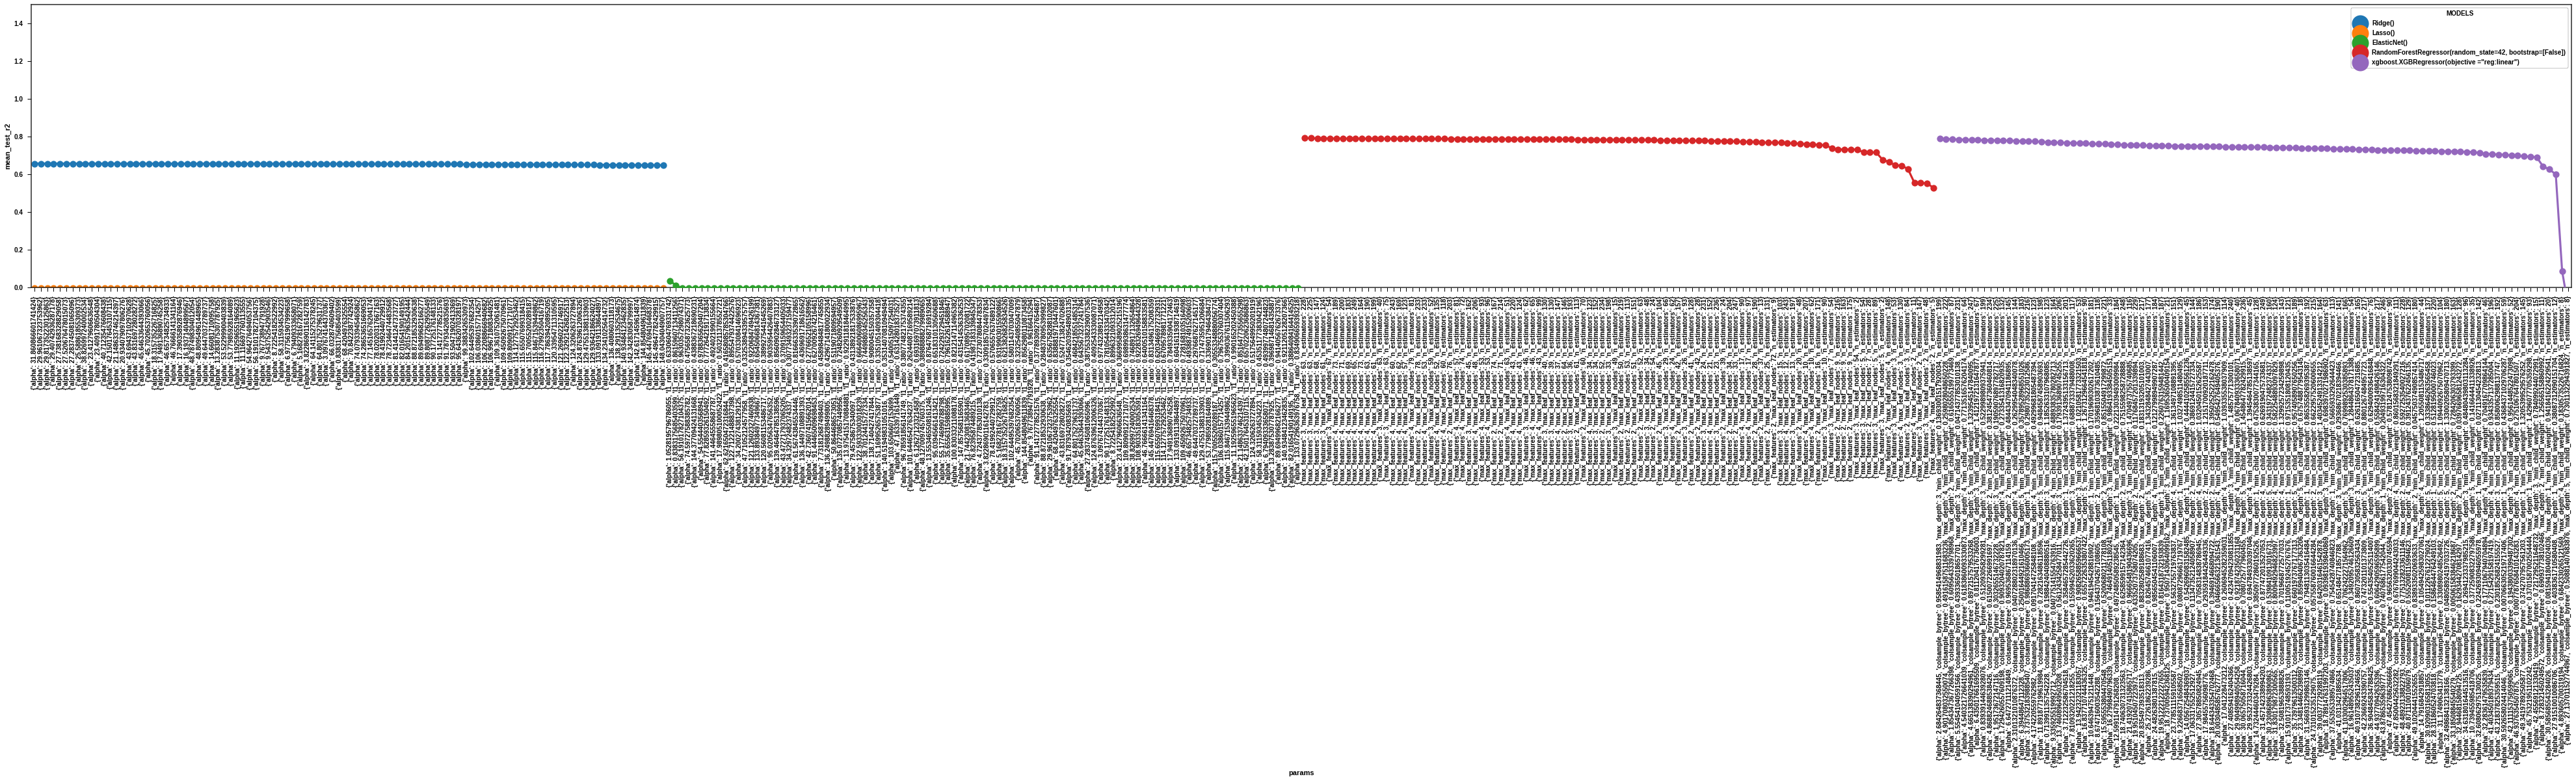

In [31]:
plt.style.use('seaborn-notebook') 
plt.rcParams["figure.figsize"] = [10*7,8]

al = dfALL_rnd.copy().reset_index()
fig, g = plt.subplots()

g = sns.pointplot(data=al, x="params", y="mean_test_r2", hue="MODELS", ci="roc_auc", capsize=.2)

g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set(ylim=(0,1.5))
#ax.set(xlim=(0,2*10**6))
fig.savefig(direc0 + '34-dfALL_rnd_sort_E_Multi.pdf', bbox_inches ="tight", pad_inches = 0.1, format='pdf')
plt.rcParams["figure.figsize"] = [10,8]

In [32]:
c = ['mean_test_r2', 'std_test_r2',
     'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
     'mean_fit_time', 'mean_score_time']

dfTOP_rnd[['params']+c].style.background_gradient(subset=c)

In [33]:
c = ['mean_test_r2',  'mean_test_neg_mean_squared_error']

dfTOP_rnd[['params']+c].style.background_gradient(subset=c)

### Best model

In [34]:
BEST_values = pd.DataFrame([np.float64(y_train)], index=['TRAIN']).T

for iMODEL in models_rnd:
    c = models_rnd.index(iMODEL)
    
    print(iMODEL)
    search = joblib.load(dirDATA + model_names_rnd[c]+'_E_Multi.pkl')
    
    # DF Comparation y_test wiht preditions models
    predictions = search.best_estimator_.fit(X_train, y_train)
    predictions = search.best_estimator_.predict(X_train)
    B_v = pd.DataFrame([predictions], index=[iMODEL]).T
    BEST_values = pd.concat([BEST_values,B_v], axis=1)
    
    # Validation
    lin_mse = mean_squared_error(np.array(y_train), np.array(predictions))
    lin_rmse = np.sqrt(lin_mse)
    lin_mae = mean_absolute_error(np.array(y_train), np.array(predictions))
    lin_r2 = r2_score(np.array(y_train), np.array(predictions)) #Pareil que: lin_reg.score(Xtest_S_E, ytest) 

    print('Mean:','%0.0f'%(y_train.mean()), '/ MSE:','%0.2f'%(lin_mse), '/ RMSE:','%0.2f'%(lin_rmse), '/ MAE:','%0.2f'%(lin_mae), '/ r2:','%0.2f'%(lin_r2), '/ RelativeError(%):','%0.1f'%(lin_rmse/y_train.mean()*100), '%')
    #print('intercept:',lin_reg.intercept_ , ', coef:',lin_reg.coef_)

Ridge()
Mean: 15 / MSE: 0.63 / RMSE: 0.80 / MAE: 0.62 / r2: 0.45 / RelativeError(%): 5.4 %
Lasso()
Mean: 15 / MSE: 1.15 / RMSE: 1.07 / MAE: 0.86 / r2: 0.00 / RelativeError(%): 7.3 %
ElasticNet()
Mean: 15 / MSE: 1.10 / RMSE: 1.05 / MAE: 0.85 / r2: 0.04 / RelativeError(%): 7.1 %
RandomForestRegressor(random_state=42, bootstrap=[False])
Mean: 15 / MSE: 0.24 / RMSE: 0.49 / MAE: 0.37 / r2: 0.79 / RelativeError(%): 3.3 %
xgboost.XGBRegressor(objective ="reg:linear")
[11:57:21] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
Mean: 15 / MSE: 0.19 / RMSE: 0.44 / MAE: 0.32 / r2: 0.84 / RelativeError(%): 3.0 %


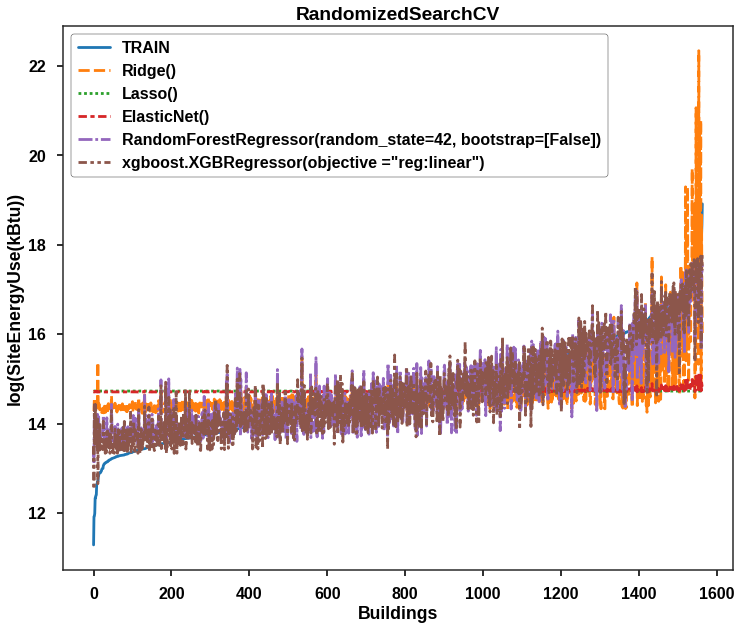

In [35]:
plt.style.use('seaborn-poster') 
BEST_values_sort = BEST_values.sort_values(['TRAIN'], ascending = True).reset_index(drop=True)
fig = plt.figure(figsize=(6*2, 5*2))
plt.rcParams['legend.loc'] = 'upper left'

ax = sns.lineplot(data=BEST_values_sort)

ax.set_title('RandomizedSearchCV')
ax.set_ylabel('log(SiteEnergyUse(kBtu))')
ax.set_xlabel('Buildings')
#ax.set_yscale('log')
#ax.set_xscale('symlog', linthresh=10000000)
plt.show()
fig.savefig(direc0 + '34-BEST_rnd_values_sort_E_Multi.pdf', bbox_inches ="tight", pad_inches = 0.1, format='pdf')

### Features contribution

In [36]:
search = joblib.load(dirDATA + model_names_rnd[3]+'_E_Multi.pkl')
final_model = search.best_estimator_
final_model

RandomForestRegressor(bootstrap=[False], max_features=3, max_leaf_nodes=63,
                      n_estimators=228, random_state=42)

 95%|=================== | 1492/1564 [00:18<00:00]       

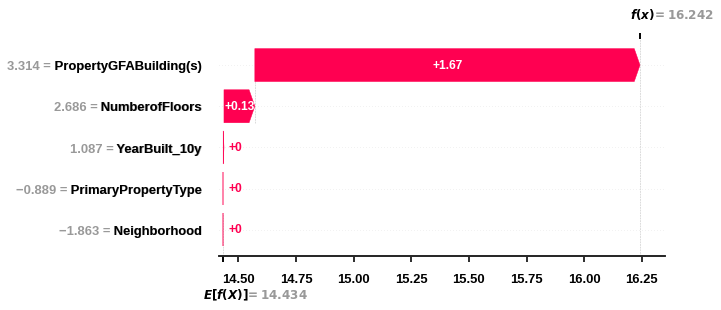

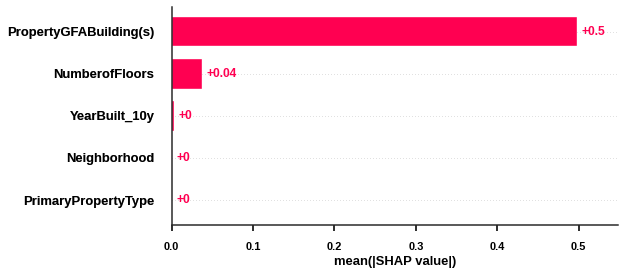

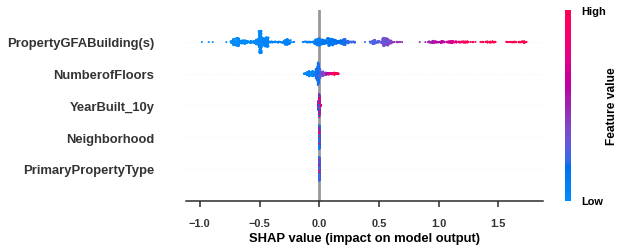

In [37]:
#vectorizer = TfidfVectorizer(min_df=10)
explainer = shap.Explainer(final_model, X_train)
shap_values = explainer(X_train)
shap.plots.waterfall(shap_values[0])
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)#, X_test_array, feature_names=vectorizer.get_feature_names())
shap.plots.force(shap_values[0]) #JupyterLab extension has not yet been written

# Fine-tune the model

## Cross-validation

dfSCORE = pd.DataFrame([], columns = dfML.describe().T.columns)
y_train = np.log(y_train)
y_val = np.log(y_val)

from sklearn.model_selection import cross_val_score
for ifd in ['LinearRegression()',  'Ridge(alpha=1, solver="cholesky")',
            'Lasso(alpha=0.1)',  'ElasticNet(alpha=0.1, l1_ratio=0.5)', 'RandomForestRegressor()']:
    scores = cross_val_score(eval(ifd), Xtest_S_E, ytest, scoring="neg_mean_squared_error", cv=2)
    
    dfSCORE.loc[ifd] = pd.Series(np.sqrt(-scores)).describe().T
dfSCORE.sort_values('max', ascending = True ,inplace = True)
dfSCORE[['count', 'mean', 'std', 'min', '25%', '50%','75%', 'max']].style.format('{0:,.1f}').background_gradient(subset=['count', 'mean', 'std', 'min', '25%', '50%','75%', 'max'])

## GridSearchCV

### Import

### Parameters

In [38]:
#Modelisation de la 'SiteEnergyUse(kBtu)'
y_train = np.log(ytrain_Energy)
y_test = np.log(ytest_Energy)
X_train = Xtrain_S_E_ylog
X_test = Xtest_S_E_ylog

In [39]:
#TEST
np.int64(np.geomspace(50, 200, num=5).round(0))
np.geomspace(0.1, 50, num=8)

array([ 0.1       ,  0.24297811,  0.5903836 ,  1.4345029 ,  3.48552798,
        8.4690699 , 20.57798569, 50.        ])

In [40]:
param_Ridge = [{'alpha': np.geomspace(0.1, 100, num=20)}]

print('combinations Ridge: ', 20)

param_RandomForestRegressor = [{'max_leaf_nodes':np.int64(np.linspace(80, 150, 4).round(0)),
                                'n_estimators': np.int64(np.geomspace(50, 500, num=5).round(0))}]
print('combinations param_RandomForestRegressor: ', 2*5)

param_XGBRegressor = [{'alpha': np.geomspace(0.01, 5, num=3),
                       'n_estimators': np.int64(np.linspace(20, 150, num=3).round(0))}]
print('combinations param_XGBRegressor: ', 3*3)

param_Grid = [param_Ridge, param_RandomForestRegressor, param_XGBRegressor]

model_names_Grid = ['Ridge_Grid', 'RandomForestRegressor_Grid', 'XGBRegressor_Grid']

models_Grid = ['Ridge()', 'RandomForestRegressor(random_state=42, bootstrap=[False], max_features=3)', 
               'xgboost.XGBRegressor(objective ="reg:linear", colsample_bytree=0.75, max_depth=3, min_child_weight=0.75)']

combinations Ridge:  20
combinations param_RandomForestRegressor:  10
combinations param_XGBRegressor:  9


### For

results_Grid = pd.DataFrame([])

for iMODEL_Grid in set(models_Grid).difference([]):
    c = models_Grid.index(iMODEL_Grid)
    
    print(iMODEL_Grid)
    #search_Grid = GridSearchCV(estimator=eval(iMODEL_Grid), param_grid=param_Grid[c], cv=10, scoring='neg_mean_squared_error', n_jobs=-1)    
    search_Grid = GridSearchCV(estimator=eval(iMODEL_Grid), param_grid=param_Grid[c], cv=10, 
                               scoring=['neg_mean_squared_error','r2'], refit='r2', n_jobs=-1)    
    
    search_Grid.fit(X_train, y_train)

    joblib.dump(search_Grid, dirDATA + model_names_Grid[c]+'_E_Multi.pkl') #search_Grid = joblib.load(model_names_Grid[c]+'_E_Multi.pkl')


### Results

In [41]:
dfALL_Grid = pd.DataFrame([])
dfTOP_Grid = pd.DataFrame([])

#models = ['xgboost.XGBRegressor(objective ="reg:linear")']

for iMODEL in models_Grid:
    c = models_Grid.index(iMODEL) #Parametres of model
    
    search = joblib.load(dirDATA + model_names_Grid[c]+'_E_Multi.pkl') #Import restulats calcule
    
    al = pd.DataFrame(search.cv_results_)
    #al['RMSE'] =  np.sqrt(-al['mean_test_score'])
    #al['std_RMSE'] =  np.sqrt(al['std_test_score'])
    al["params"] = al["params"].astype('str').convert_dtypes()
    al = al.sort_values(['rank_test_r2'], ascending = False)    #r = pd.DataFrame(search.cv_results_)

    al = pd.concat([al], keys=[iMODEL], names=['MODELS'], axis = 0)
    dfALL_Grid = pd.concat([dfALL_Grid,al], axis = 0)

    t = al.iloc[:1]
    #tt = pd.concat([t], keys=[iMODEL], names=['MODELS'], axis = 0)
    dfTOP_Grid = pd.concat([dfTOP_Grid,t], axis = 0)

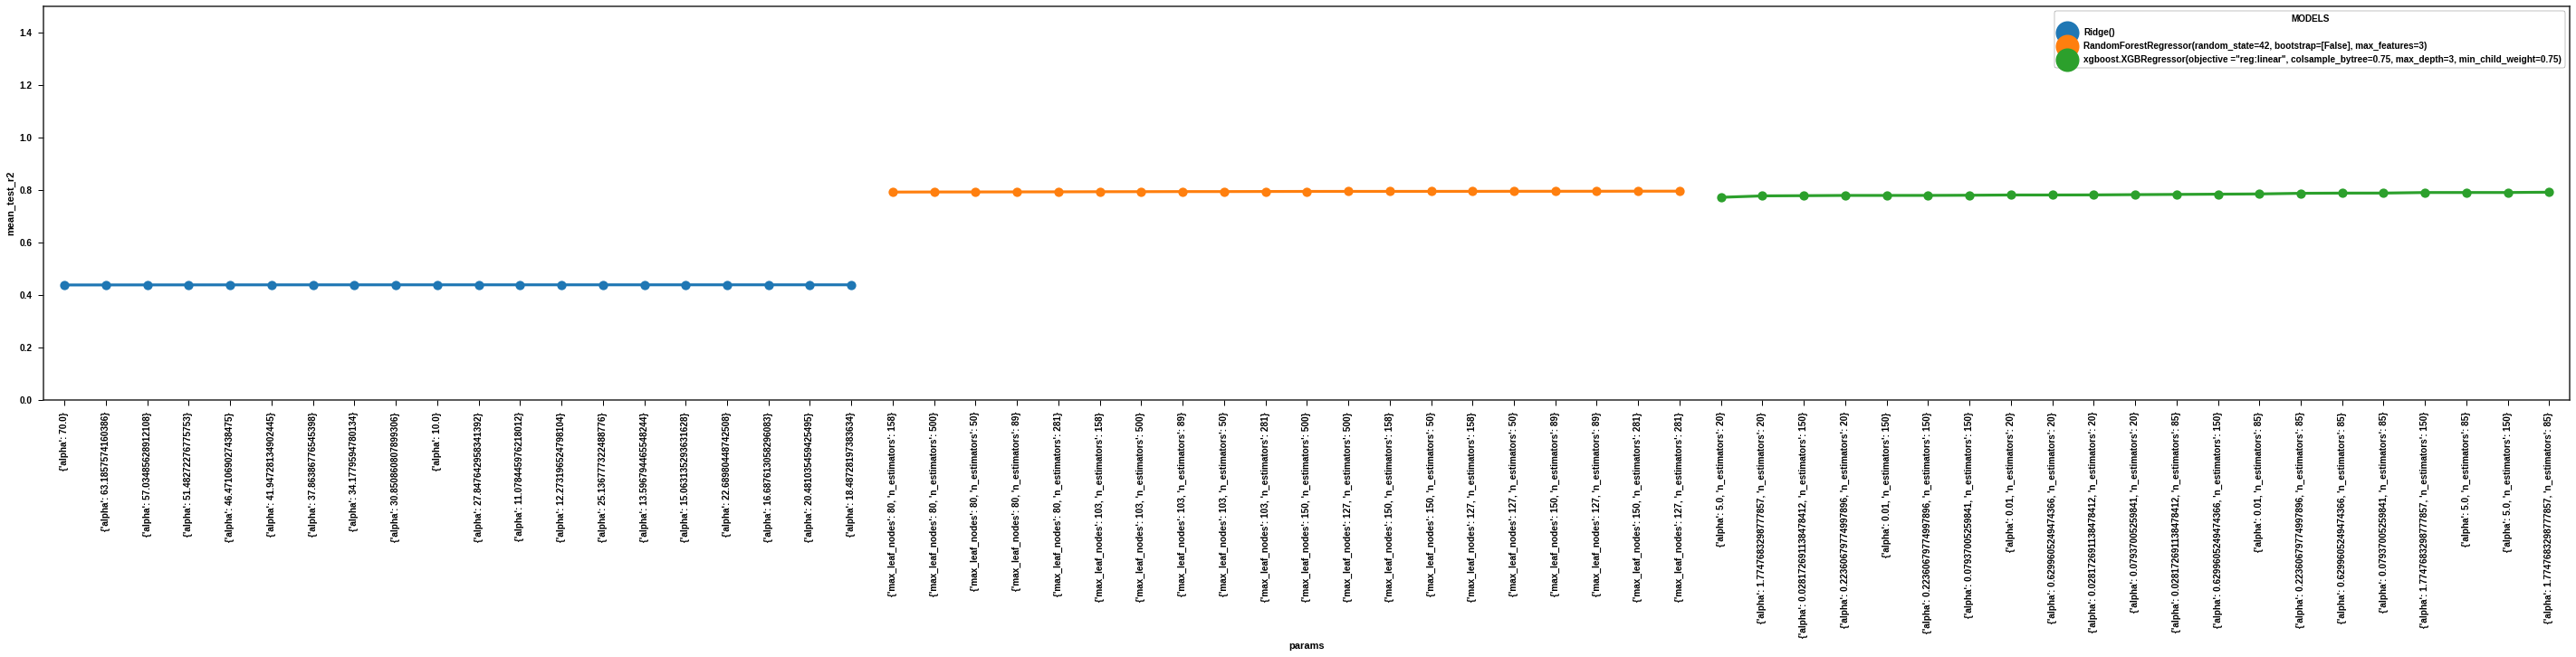

In [42]:
plt.style.use('seaborn-notebook') 
plt.rcParams["figure.figsize"] = [10*5,8]

al = dfALL_Grid.copy().reset_index()
fig, g = plt.subplots()

g = sns.pointplot(data=al, x="params", y="mean_test_r2", hue="MODELS", ci="roc_auc", capsize=.2)

g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set(ylim=(0,1.5))
#ax.set(xlim=(0,2*10**6))
fig.savefig(direc0 + '34-dfALL_Grid_sort_E_Multi.pdf', bbox_inches ="tight", pad_inches = 0.1, format='pdf')
plt.rcParams["figure.figsize"] = [10,8]

In [43]:
c = ['mean_test_r2', 'std_test_r2',
     'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
     'mean_fit_time', 'mean_score_time']

dfTOP_Grid[['params']+c].style.background_gradient(subset=c)

,,params,mean_test_r2,std_test_r2,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,mean_fit_time,mean_score_time
MODELS,,,,,,,,
Ridge(),19,{'alpha': 70.0},0.437702,0.056919,-0.642923,0.072569,0.003223,0.002787
"RandomForestRegressor(random_state=42, bootstrap=[False], max_features=3)",2,"{'max_leaf_nodes': 80, 'n_estimators': 158}",0.791797,0.037869,-0.237118,0.040681,0.827054,0.053177
"xgboost.XGBRegressor(objective =""reg:linear"", colsample_bytree=0.75, max_depth=3, min_child_weight=0.75)",18,"{'alpha': 5.0, 'n_estimators': 20}",0.771817,0.044174,-0.259736,0.046465,0.108026,0.017507


In [44]:
c = ['mean_test_r2', 'mean_test_neg_mean_squared_error']

dfTOP_Grid[['params']+c].style.background_gradient(subset=c)

,,params,mean_test_r2,mean_test_neg_mean_squared_error
MODELS,,,,
Ridge(),19,{'alpha': 70.0},0.437702,-0.642923
"RandomForestRegressor(random_state=42, bootstrap=[False], max_features=3)",2,"{'max_leaf_nodes': 80, 'n_estimators': 158}",0.791797,-0.237118
"xgboost.XGBRegressor(objective =""reg:linear"", colsample_bytree=0.75, max_depth=3, min_child_weight=0.75)",18,"{'alpha': 5.0, 'n_estimators': 20}",0.771817,-0.259736


### Best model

In [45]:
BEST_values = pd.DataFrame([np.float64(y_train)], index=['TRAIN']).T

for iMODEL in models_Grid:
    c = models_Grid.index(iMODEL)
    
    print(iMODEL)
    search = joblib.load(dirDATA + model_names_Grid[c]+'_E_Multi.pkl')
    
    # DF Comparation y_test wiht preditions models
    predictions = search.best_estimator_.fit(X_train, y_train)
    predictions = search.best_estimator_.predict(X_train)
    B_v = pd.DataFrame([predictions], index=[iMODEL]).T
    BEST_values = pd.concat([BEST_values,B_v], axis=1)
    
    # Validation
    lin_mse = mean_squared_error(np.array(y_train), np.array(predictions))
    lin_rmse = np.sqrt(lin_mse)
    lin_mae = mean_absolute_error(np.array(y_train), np.array(predictions))
    lin_r2 = r2_score(np.array(y_train), np.array(predictions)) #Pareil que: lin_reg.score(Xtest_S_E, ytest) 

    print('Mean:','%0.0f'%(y_train.mean()), '/ MSE:','%0.2f'%(lin_mse), '/ RMSE:','%0.2f'%(lin_rmse), '/ MAE:','%0.2f'%(lin_mae), '/ r2:','%0.2f'%(lin_r2), '/ RelativeError(%):','%0.1f'%(lin_rmse/y_train.mean()*100), '%')
    #print('intercept:',lin_reg.intercept_ , ', coef:',lin_reg.coef_)

Ridge()
Mean: 15 / MSE: 0.63 / RMSE: 0.80 / MAE: 0.62 / r2: 0.45 / RelativeError(%): 5.4 %
RandomForestRegressor(random_state=42, bootstrap=[False], max_features=3)
Mean: 15 / MSE: 0.17 / RMSE: 0.42 / MAE: 0.32 / r2: 0.85 / RelativeError(%): 2.8 %
xgboost.XGBRegressor(objective ="reg:linear", colsample_bytree=0.75, max_depth=3, min_child_weight=0.75)
[11:57:50] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
Mean: 15 / MSE: 0.19 / RMSE: 0.43 / MAE: 0.32 / r2: 0.84 / RelativeError(%): 2.9 %


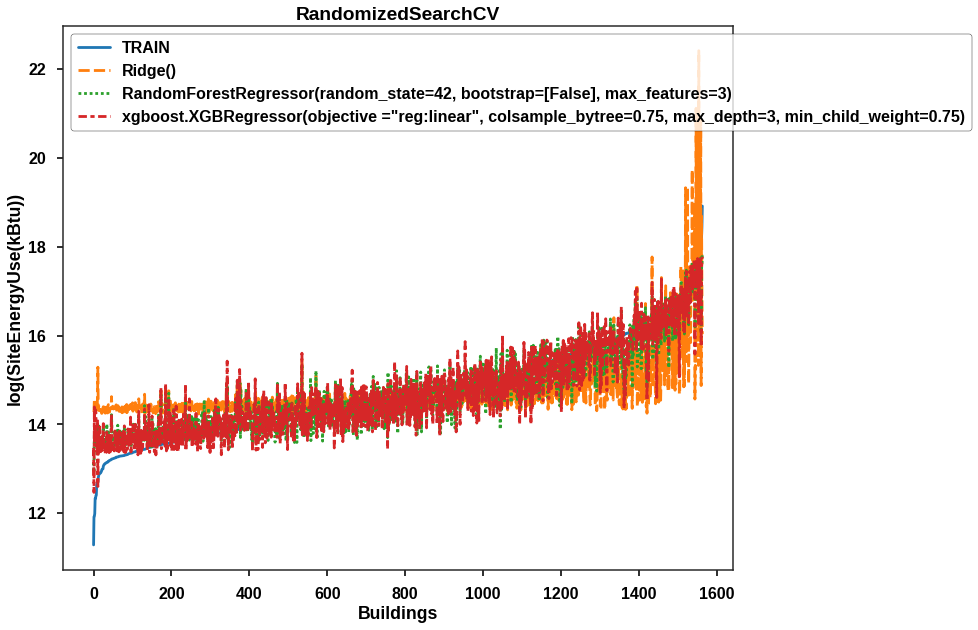

In [46]:
plt.style.use('seaborn-poster') 
BEST_values_sort = BEST_values.sort_values(['TRAIN'], ascending = True).reset_index(drop=True)
fig = plt.figure(figsize=(6*2, 5*2))
plt.rcParams['legend.loc'] = 'upper left'

ax = sns.lineplot(data=BEST_values_sort)

ax.set_title('RandomizedSearchCV')
ax.set_ylabel('log(SiteEnergyUse(kBtu))')
ax.set_xlabel('Buildings')
#ax.set_yscale('log')
#ax.set_xscale('symlog', linthresh=10000000)
plt.show()
fig.savefig(direc0 + '34-BEST_Grid_values_sort_E_Multi.pdf', bbox_inches ="tight", pad_inches = 0.1, format='pdf')

### Features contribution

In [47]:
search = joblib.load(dirDATA + model_names_Grid[1]+'_E_Multi.pkl')
final_model = search.best_estimator_
final_model

RandomForestRegressor(bootstrap=[False], max_features=3, max_leaf_nodes=127,
                      n_estimators=281, random_state=42)

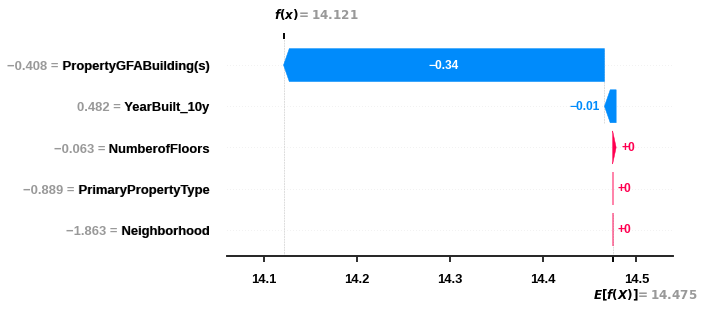

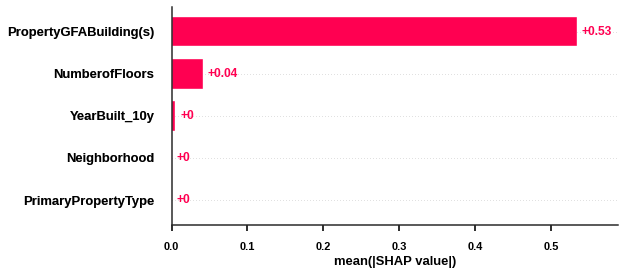

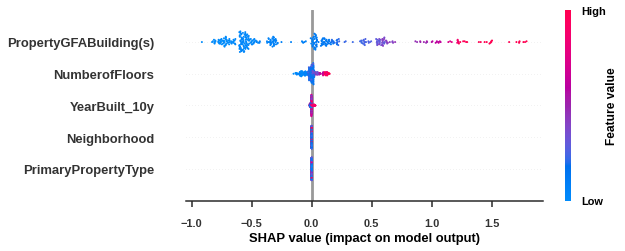

In [48]:
vectorizer = TfidfVectorizer(min_df=10)
explainer = shap.Explainer(final_model, X_test)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)#, X_test_array, feature_names=vectorizer.get_feature_names())
shap.plots.force(shap_values[0]) #JupyterLab extension has not yet been written

# Evaluation

## Parameters

In [49]:
#Modelisation de la 'SiteEnergyUse(kBtu)'
y_train = np.log(ytrain_Energy)
y_test = np.log(ytest_Energy)
X_train = Xtrain_S_E_ylog
X_test = Xtest_S_E_ylog

## Results

In [50]:
c = ['mean_test_r2', 'std_test_r2',
     'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error',
     'mean_fit_time', 'mean_score_time']

dfTOP_Grid[['params']+c].style.background_gradient(subset=c)

,,params,mean_test_r2,std_test_r2,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,mean_fit_time,mean_score_time
MODELS,,,,,,,,
Ridge(),19,{'alpha': 70.0},0.437702,0.056919,-0.642923,0.072569,0.003223,0.002787
"RandomForestRegressor(random_state=42, bootstrap=[False], max_features=3)",2,"{'max_leaf_nodes': 80, 'n_estimators': 158}",0.791797,0.037869,-0.237118,0.040681,0.827054,0.053177
"xgboost.XGBRegressor(objective =""reg:linear"", colsample_bytree=0.75, max_depth=3, min_child_weight=0.75)",18,"{'alpha': 5.0, 'n_estimators': 20}",0.771817,0.044174,-0.259736,0.046465,0.108026,0.017507


In [51]:
c = ['mean_test_r2', 'mean_test_neg_mean_squared_error']

dfTOP_Grid[['params']+c].style.background_gradient(subset=c)

,,params,mean_test_r2,mean_test_neg_mean_squared_error
MODELS,,,,
Ridge(),19,{'alpha': 70.0},0.437702,-0.642923
"RandomForestRegressor(random_state=42, bootstrap=[False], max_features=3)",2,"{'max_leaf_nodes': 80, 'n_estimators': 158}",0.791797,-0.237118
"xgboost.XGBRegressor(objective =""reg:linear"", colsample_bytree=0.75, max_depth=3, min_child_weight=0.75)",18,"{'alpha': 5.0, 'n_estimators': 20}",0.771817,-0.259736


## Best model

In [52]:
BEST_values = pd.DataFrame([np.float64(y_test)], index=['TEST']).T
dfTOP_Best = pd.DataFrame([], index=dfTOP_Grid.droplevel(1,axis=0).index, columns=['params','mean_test_r2', 'mean_test_neg_mean_squared_error'])
dfTOP_Best['params'] = dfTOP_Grid['params'].droplevel(1,axis=0)
for iMODEL in models_Grid:
    c = models_Grid.index(iMODEL)
    
    print(iMODEL)
    search = joblib.load(dirDATA + model_names_Grid[c]+'_E_Multi.pkl')
    
    # DF Comparation y_test wiht preditions models
    predictions = search.best_estimator_.fit(X_test, y_test)
    predictions = search.best_estimator_.predict(X_test)
    B_v = pd.DataFrame([predictions], index=[iMODEL]).T
    BEST_values = pd.concat([BEST_values,B_v], axis=1)
    
    # Validation
    lin_mse = mean_squared_error(np.array(y_test), np.array(predictions))
    lin_rmse = np.sqrt(lin_mse)
    lin_mae = mean_absolute_error(np.array(y_test), np.array(predictions))
    lin_r2 = r2_score(np.array(y_test), np.array(predictions)) #Pareil que: lin_reg.score(Xtest_S_E, ytest) 

    dfTOP_Best.loc[iMODEL, ['mean_test_r2', 'mean_test_neg_mean_squared_error']] = [lin_r2, lin_mse]
    
    #print('Mean:','%0.0f'%(y_test.mean()), '/ MSE:','%0.2f'%(lin_mse), '/ RMSE:','%0.2f'%(lin_rmse), '/ MAE:','%0.2f'%(lin_mae), '/ r2:','%0.2f'%(lin_r2), '/ RelativeError(%):','%0.1f'%(lin_rmse/y_test.mean()*100), '%')
    #print('intercept:',lin_reg.intercept_ , ', coef:',lin_reg.coef_)

Ridge()
RandomForestRegressor(random_state=42, bootstrap=[False], max_features=3)
xgboost.XGBRegressor(objective ="reg:linear", colsample_bytree=0.75, max_depth=3, min_child_weight=0.75)
[11:57:59] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


In [53]:
c = ['mean_test_r2', 'mean_test_neg_mean_squared_error']

dfTOP_Best[['params']+c].style.background_gradient(subset=c)

,params,mean_test_r2,mean_test_neg_mean_squared_error
MODELS,,,
Ridge(),{'alpha': 70.0},0.464058,0.693676
"RandomForestRegressor(random_state=42, bootstrap=[False], max_features=3)","{'max_leaf_nodes': 80, 'n_estimators': 158}",0.945845,0.070093
"xgboost.XGBRegressor(objective =""reg:linear"", colsample_bytree=0.75, max_depth=3, min_child_weight=0.75)","{'alpha': 5.0, 'n_estimators': 20}",0.892647,0.138948


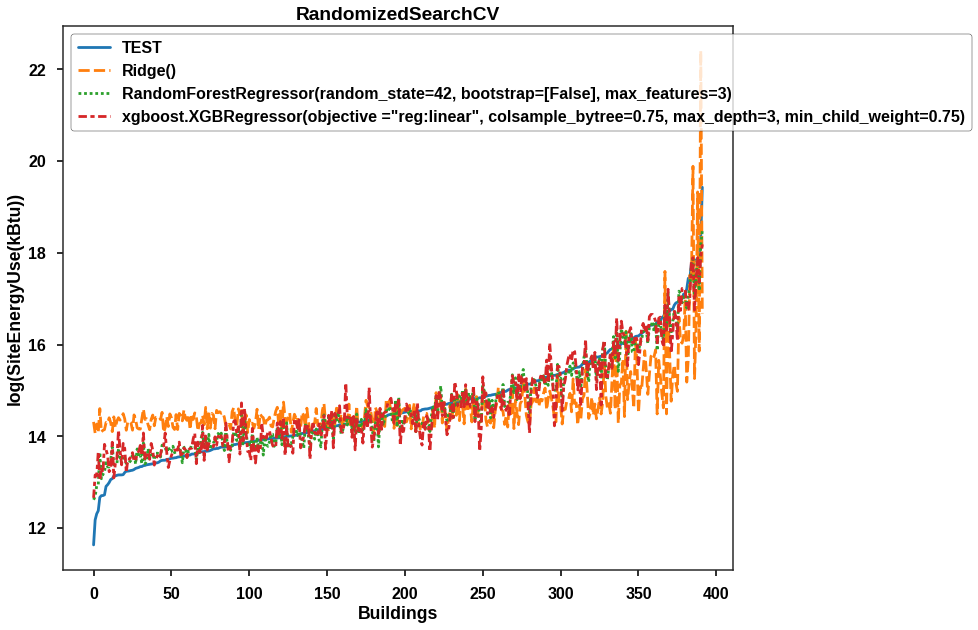

In [54]:
plt.style.use('seaborn-poster') 
BEST_values_sort = BEST_values.sort_values(['TEST'], ascending = True).reset_index(drop=True)
fig = plt.figure(figsize=(6*2, 5*2))
plt.rcParams['legend.loc'] = 'upper left'

ax = sns.lineplot(data=BEST_values_sort)

ax.set_title('RandomizedSearchCV')
ax.set_ylabel('log(SiteEnergyUse(kBtu))')
ax.set_xlabel('Buildings')
#ax.set_yscale('log')
#ax.set_xscale('symlog', linthresh=10000000)
plt.show()
fig.savefig(direc0 + '34-BEST_best_values_sort_E_Multi.pdf', bbox_inches ="tight", pad_inches = 0.1, format='pdf')

## Selected model : RandomForestRegressor

In [55]:
search = joblib.load(dirDATA + model_names_Grid[1]+'_E_Multi.pkl')
final_model = search.best_estimator_
final_model

RandomForestRegressor(bootstrap=[False], max_features=3, max_leaf_nodes=127,
                      n_estimators=281, random_state=42)

In [56]:
np.e**BEST_values.iloc[:,[0,2]]

,TEST,"RandomForestRegressor(random_state=42, bootstrap=[False], max_features=3)"
0,821860.5,9.966841e+05
1,953432.2,1.049526e+06
2,2067352.5,1.927752e+06
3,968026.3,9.625850e+05
4,2606130.8,2.499838e+06
...,...,...
387,1642471.5,1.394667e+06
388,917728.4,1.053587e+06
389,2796425.0,1.596588e+06
390,1207869.9,9.345521e+05


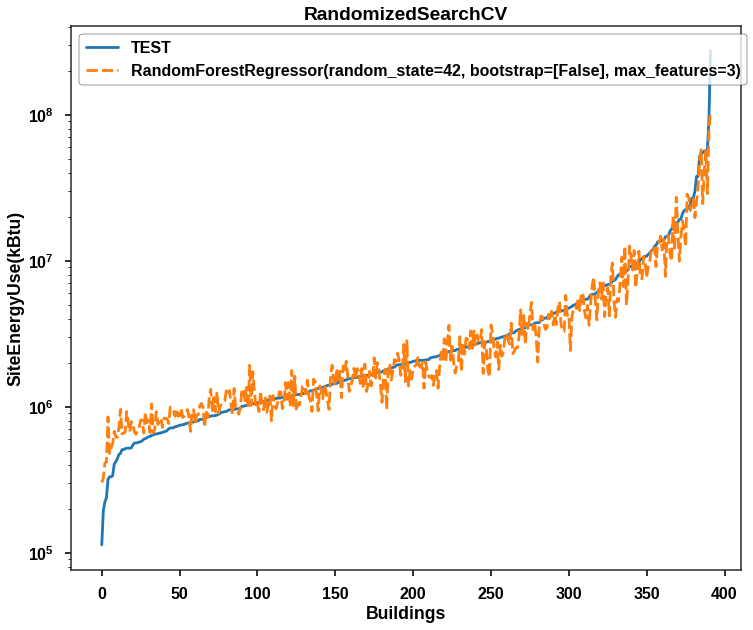

In [57]:
plt.style.use('seaborn-poster') 
BEST_values_sort = np.e**BEST_values.iloc[:,[0,2]].sort_values(['TEST'], ascending = True).reset_index(drop=True)
fig = plt.figure(figsize=(6*2, 5*2))
plt.rcParams['legend.loc'] = 'upper left'

ax = sns.lineplot(data=BEST_values_sort)

ax.set_title('RandomizedSearchCV')
ax.set_ylabel('SiteEnergyUse(kBtu)')
ax.set_xlabel('Buildings')

#ax.set(ylim=(0,10**16))

ax.set_yscale('log')
#ax.set_xscale('symlog', linthresh=10000000)
plt.show()
fig.savefig(direc0 + '54-SELECTED_Modelvalues_sort_E_Multi.pdf', bbox_inches ="tight", pad_inches = 0.1, format='pdf')

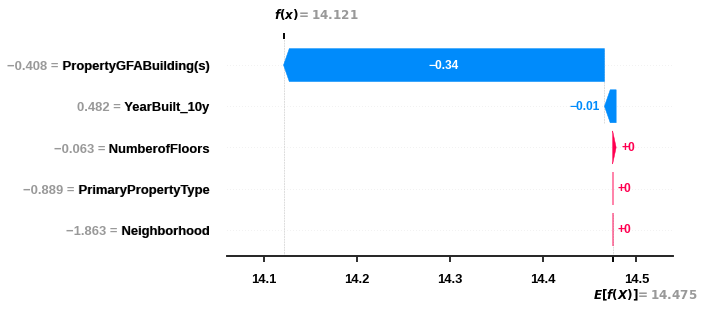

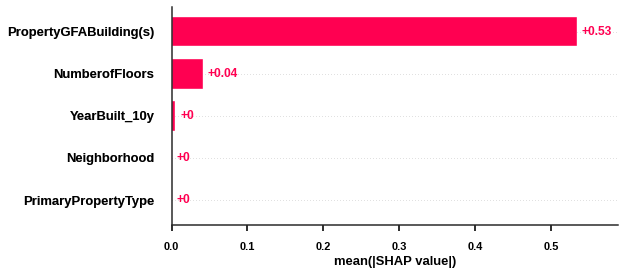

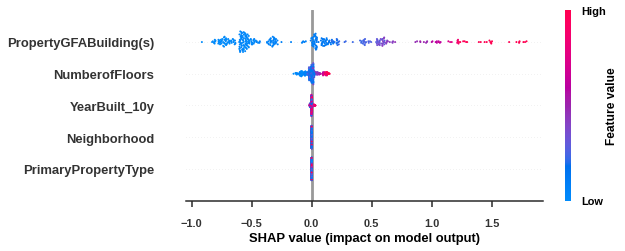

In [58]:
vectorizer = TfidfVectorizer(min_df=10)
explainer = shap.Explainer(final_model, X_test)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)#, X_test_array, feature_names=vectorizer.get_feature_names())
shap.plots.force(shap_values[0]) #JupyterLab extension has not yet been written

# Export dfML

## SiteEnergyUse(kBtu)_predicted

In [59]:
final_model

RandomForestRegressor(bootstrap=[False], max_features=3, max_leaf_nodes=127,
                      n_estimators=281, random_state=42)

In [60]:
prediction = final_model.predict(X_test)
a = np.e**pd.DataFrame([prediction], columns=X_test.index).T
prediction = search.best_estimator_.predict(X_train)
b = np.e**pd.DataFrame([prediction], columns=X_train.index).T
c = pd.concat([a,b])
dfML['SiteEnergyUse(kBtu)_predicted'] = c

## Export

In [61]:
dfML.to_csv(direc0 + 'dfML_Energy_predicted_Multi.csv', index=False)
dfML

,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e),PropertyGFABuilding(s),NumberofFloors,PrimaryPropertyType,Neighborhood,YearBuilt_10y,ENERGYSTARScore,SiteEnergyUse(kBtu)_predicted
OSEBuildingID,,,,,,,,,
27869,79711.8,0.87,23040,3,warehouse,east,1920,99,7.199361e+05
23342,113130.0,2.69,21936,2,warehouse,north,1970,100,7.604871e+05
24955,150167.8,1.6,16300,2,distribution center,greater duwamish,1950,100,5.770600e+05
797,151754.3,1.06,71718,2,distribution center,greater duwamish,1960,100,1.590666e+06
21382,161311.1,1.12,36444,2,warehouse,ballard,1960,80,9.397630e+05
...,...,...,...,...,...,...,...,...,...
63,80469220.0,2451.58,847518,35,hotel,downtown,1980,63,1.266383e+07
775,92937640.0,882.56,1632820,77,large office,downtown,1980,86,1.286415e+07
23113,102673700.0,3238.24,591981,4,medical office,east,1960,60,1.013647e+07
